# Smart Supply Chain Project
## Benjamin Blankartz
### AMEND Consulting Project

The aim of this project is to develop a predictive model which could indicate a loss of benefit for an order. I chose supply chain data because I believe that it reflects a common problem that a management consulting company may face. The datasource for this project is located here: https://www.kaggle.com/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis.  Simply copy the 3 data files into the /data/ folder.  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl 
import seaborn as sns
import imblearn as imb
import warnings
warnings.filterwarnings('ignore')
#print(skl.__version__)
pd.set_option('max_columns', None)

In [2]:
#Import the data - This would be more complicated if the data was not provided in a flat file. 
df = pd.read_csv('./data/DataCoSupplyChainDataset.csv',delimiter=',')
print("Rows,Columns: " + str(df.shape))

Rows,Columns: (180519, 53)


### Pre-analysis 
Normally, buisness experience and client knowledge can help drive this portion. Our greatest insight will come from the the attached file "DescriptionDataCoSupplyChain.csv". This file gives context to the column names.  Using this file, we can begin to better understand the layout of the data using Pandas and Matplotlib.

In [3]:
#Examine the first several rows so we can understand what our possible features are.  
df.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajast�n,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajast�n,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [4]:
#Check the meta data of the columns.  Note: there seems to be several null fields and all non-numerics are objects.  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [5]:
#Describe will give us quick statistics for the numeral columns.  Columns such as 'Zipcode' are not useful.  But anything dealing with sales values or shipping time could be of use.   
df.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,-84.915675,6691.379495,36221.894903,692.509764,20.664741,0.101668,90260.000000,141.232550,0.120647,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,21.433241,4162.918106,21045.379569,336.446807,21.800901,0.070415,52111.490959,139.732492,0.466796,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025986,1.000000,1.000000,19.000000,0.000000,0.000000,1.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,-98.446312,3258.500000,18057.000000,403.000000,5.400000,0.040000,45130.500000,50.000000,0.080000,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,-76.847908,6457.000000,36140.000000,627.000000,14.000000,0.100000,90260.000000,59.990002,0.270000,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,-66.370583,9779.000000,54144.000000,1004.000000,29.990000,0.160000,135389.500000,199.990005,0.360000,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,115.263077,20757.000000,77204.000000,1363.000000,500.000000,0.250000,180519.000000,1999.989990,0.500000,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


### Feature Creation and Further Analysis
I perform some basic feature creation.  First I would like to extract a "Year" column to use later.  Finally, I create a column to indicate if a sale had a net negative balance or not.  This will be our main target later.  

I then start examing some of the trends in orders that ended as a net value lost.

In [6]:
#Net benefit catagorical feature
df['Value_Loss'] = np.where(df['Benefit per order'] < 0,1,0)
df['Value_Loss'].describe()

count    180519.000000
mean          0.187149
std           0.390032
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Value_Loss, dtype: float64

In [7]:
#Date time feature creation 
df['Order_Date'] = pd.to_datetime(df['order date (DateOrders)'])
df['Order_Year'] = df['Order_Date'].dt.year

In [8]:
#Drop columns with ID in name to simplify- This step should be done during inital data engineering and importing.  
df_noID = df[df.columns.drop(list(df.filter(regex=' Id')))]
df_noID.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Value_Loss,Order_Date,Order_Year
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,13.110000,0.04,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class,0,2018-01-31 22:56:00,2018
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,1/13/2018 12:27,16.389999,0.05,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajast�n,PENDING,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class,1,2018-01-13 12:27:00,2018
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,1/13/2018 12:06,18.030001,0.06,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajast�n,CLOSED,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class,1,2018-01-13 12:06:00,2018
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,1/13/2018 11:45,22.940001,0.07,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class,0,2018-01-13 11:45:00,2018
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,1/13/2018 11:24,29.500000,0.09,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class,0,2018-01-13 11:24:00,2018


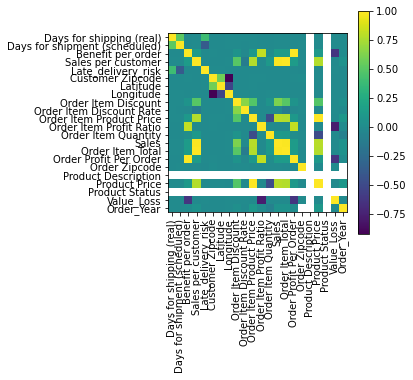

In [9]:
#Generate correlation graph.  
corr_no_ID = df_noID.corr()
corrPlot = plt.matshow(corr_no_ID )
plt.xticks(range(len(corr_no_ID .columns)), corr_no_ID .columns, rotation=90)
plt.yticks(range(len(corr_no_ID .columns)), corr_no_ID .columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrPlot)
plt.show()

In [10]:
#Create a dataset only housing the loss data
is_value_loss = df_noID["Value_Loss"]==1
loss_data = df_noID[is_value_loss]
net_loss = loss_data["Benefit per order"].sum()
print("Total loss of profit: {:.2f}".format(abs(net_loss)))

Total loss of profit: 3883547.35


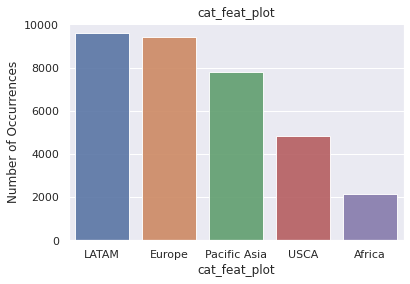

In [11]:
#Explore the catagorical features
cat_feat_plot = 'Market'
count = loss_data[cat_feat_plot].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('cat_feat_plot')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('cat_feat_plot', fontsize=12)
plt.show()

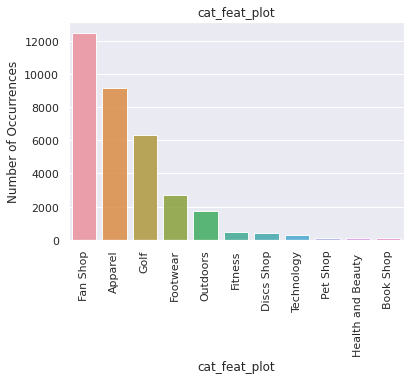

In [12]:
#Explore the catagorical features
cat_feat_plot = 'Department Name'
count = loss_data[cat_feat_plot].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('cat_feat_plot')
plt.xticks(rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('cat_feat_plot', fontsize=12)
plt.show()

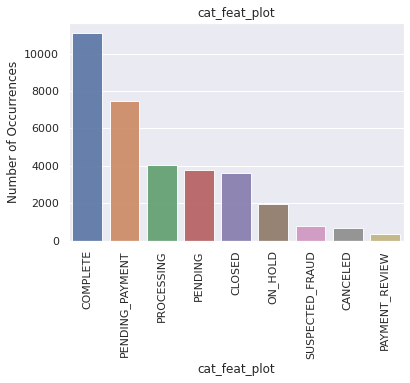

In [13]:
#Order status is interesting.  Several of the catagories could not be known at the time of an order, ie. "Suspected Fraud"
cat_feat_plot = 'Order Status'
count = loss_data[cat_feat_plot].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('cat_feat_plot')
plt.xticks(rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('cat_feat_plot', fontsize=12)
plt.show()

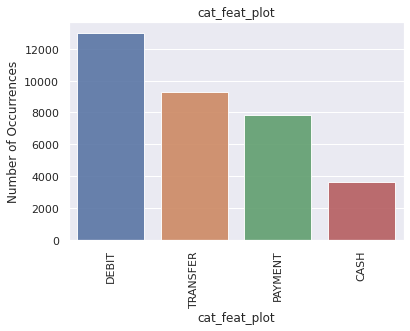

In [14]:
#Type indicates the payment method used.  
cat_feat_plot = 'Type'
count = loss_data[cat_feat_plot].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('cat_feat_plot')
plt.xticks(rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('cat_feat_plot', fontsize=12)
plt.show()

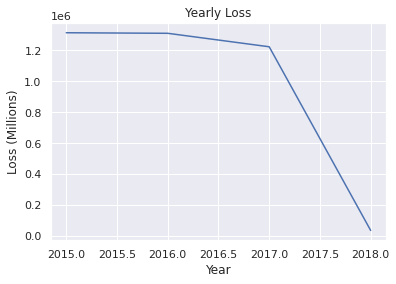

In [15]:
#Plot of loss per year.  Around 2017, something changes this.  
yearly_loss = loss_data.groupby(by=['Order_Year']).sum()
yearly_loss['Benefit per order'] = yearly_loss['Benefit per order'].abs()
sns.set(style="darkgrid")
sns.lineplot(data=yearly_loss, x='Order_Year', y="Benefit per order")
plt.title('Yearly Loss')
plt.ylabel('Loss (Millions)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

### Model Building
We will utilize a random forrest due to the robustness of the model.  

Basic steps:
<ol>
<li>Feature selection</li>
<li>Class balancing</li>
<li>Train/Test grouping</li>
<li>Model initialization and training</li>
</ol>


In [16]:
#Feature selection
features = ['Customer State','Customer Street','Customer Zipcode','Latitude','Longitude','Market','Value_Loss','Order Region','Order State', 'Sales','Type','Product Name','Department Name']
model_data = df[features]
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer State    180519 non-null  object 
 1   Customer Street   180519 non-null  object 
 2   Customer Zipcode  180516 non-null  float64
 3   Latitude          180519 non-null  float64
 4   Longitude         180519 non-null  float64
 5   Market            180519 non-null  object 
 6   Value_Loss        180519 non-null  int64  
 7   Order Region      180519 non-null  object 
 8   Order State       180519 non-null  object 
 9   Sales             180519 non-null  float64
 10  Type              180519 non-null  object 
 11  Product Name      180519 non-null  object 
 12  Department Name   180519 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 17.9+ MB


In [17]:
import sklearn.model_selection as mskl

In [18]:
from sklearn.preprocessing import LabelEncoder

#Final data cleaning
model_data.dropna(inplace=True)
indices_to_keep = ~model_data.isin([np.nan, np.inf, -np.inf]).any(1)
model_data = model_data[indices_to_keep]

#Select features and classes
y = model_data['Value_Loss']
X = model_data.drop(columns=['Value_Loss'])

#Create dummie labels for catagorical data
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == "object":
        encode = LabelEncoder()
        X[col] = encode.fit_transform(X[col])

#Note: Label Encoding could be creating a signal via ordinal numbers

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180516 entries, 0 to 180518
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer State    180516 non-null  int64  
 1   Customer Street   180516 non-null  int64  
 2   Customer Zipcode  180516 non-null  float64
 3   Latitude          180516 non-null  float64
 4   Longitude         180516 non-null  float64
 5   Market            180516 non-null  int64  
 6   Order Region      180516 non-null  int64  
 7   Order State       180516 non-null  int64  
 8   Sales             180516 non-null  float64
 9   Type              180516 non-null  int64  
 10  Product Name      180516 non-null  int64  
 11  Department Name   180516 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 17.9 MB


In [19]:
#We will need to resample the data since the target catagory is imbalanced- Note that this will take a moment
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0,n_jobs=-1)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

#X_train, X_test, y_train, y_test = mskl.train_test_split(X, y, test_size=0.33, random_state=1)

X_train, X_test, y_train, y_test = mskl.train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=1)
X_test.head()

,Customer State,Customer Street,Customer Zipcode,Latitude,Longitude,Market,Order Region,Order State,Sales,Type,Product Name,Department Name
45100,38,1250,77081.000000,26.172918,-97.683289,1,17,204,200.000000,3,59,6
58004,34,5804,725.000000,18.215712,-66.370560,3,13,1019,399.980011,2,24,3
130547,34,6579,725.000000,18.225757,-66.370536,1,14,630,499.950012,2,61,5
66840,3,6996,92653.000000,33.612175,-117.709679,1,10,334,149.940002,2,67,3
146045,4,1465,80012.405983,39.743883,-104.857202,1,9,655,351.849957,1,41,4


In [20]:
#Initialize random forrest classifier.  Note that I did perform some optimization on this model, but it is commented out due to performance requirements. 
from sklearn.ensemble import RandomForestClassifier
regc = RandomForestClassifier(random_state=0,n_jobs=-1,n_estimators=700)
regc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=0)

#### Optimization 
##### WARNING: This will require ~10 minutes to run.  Disable markdown and uncomment below to run.
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 700]
max_depth = [4, 32, 64, 128]
min_samples_split = [2,3]
min_samples_leaf = [1,2] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(regc, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

#Comment for saftey

#bestF = gridF.fit(X_train, y_train)

print(bestF.score(Xtest,y_test)) 

print(bestF.best_params)

In [21]:
#Score the model!
print(regc.score(X_test,y_test))

0.8821861106852675


### Model Validation and Exploration
We should try to gain some understanding of what the model is accomplishing so that it can be relayed back to the client. 

12


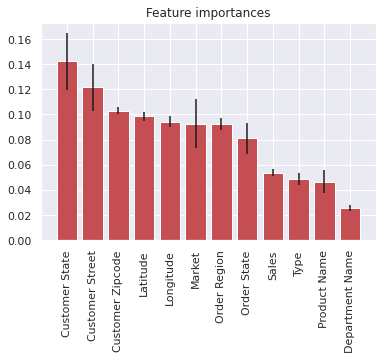

In [22]:
#Plot of feature importance
print(X.shape[1])
importances = regc.feature_importances_
std = np.std([tree.feature_importances_ for tree in regc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#print(importances)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns,rotation=90)

plt.xlim([-1, X.shape[1]])
plt.show()

Text(0.5, 1.0, "Confusion Matrix- '1' indicates a loss.")

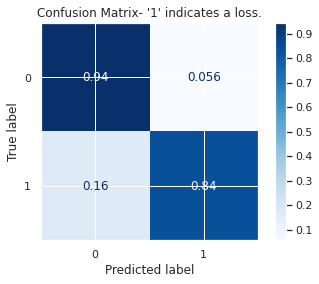

In [23]:
#Basic confusion matrix.  
from sklearn.metrics import plot_confusion_matrix
title = "Confusion Matrix- '1' indicates a loss."
disp = plot_confusion_matrix(regc, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title(title)
#print(disp.confusion_matrix)

In [24]:
#Dirty method for me to quickily make a prediction data set
X_0, X_1, y_0, y_1 = mskl.train_test_split(X, y, test_size=0.33, random_state=1)
prediction = regc.predict(X_1)

In [25]:
prediction_data = X_1
prediction_data= prediction_data.join(df_noID,lsuffix='_m',rsuffix='_original',how='inner')
prediction_data['Value_Loss_Prediciton'] = prediction
prediction_data.describe()

,Customer State_m,Customer Street_m,Customer Zipcode_m,Latitude_m,Longitude_m,Market_m,Order Region_m,Order State_m,Sales_m,Type_m,Product Name_m,Department Name_m,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Customer Zipcode_original,Latitude_original,Longitude_original,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales_original,Order Item Total,Order Profit Per Order,Order Zipcode,Product Description,Product Price,Product Status,Value_Loss,Order_Year,Value_Loss_Prediciton
count,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.00000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,8309.000000,0.0,59571.000000,59571.0,59571.000000,59571.000000,59571.000000
mean,24.253798,3710.717312,35618.508687,29.606563,-84.780968,2.114703,12.123080,552.42284,204.218579,1.670528,58.423998,3.253680,3.489298,2.928489,22.340669,183.550003,0.544392,35618.508687,29.606563,-84.780968,20.668833,0.101514,142.121003,0.122565,2.121133,204.218579,183.550003,22.340669,55396.659767,NaN,142.121003,0.0,0.184821,2015.975777,0.127293
std,13.040026,2149.394763,37541.225241,9.822263,21.477938,1.153526,6.976677,306.97940,132.122585,0.996236,23.550193,2.500913,1.626971,1.376689,105.771629,120.034998,0.498030,37541.225241,9.822263,21.477938,21.842608,0.070536,139.837709,0.464455,1.452741,132.122585,120.034998,105.771629,31855.844753,NaN,139.837709,0.0,0.388156,0.830023,0.333304
min,0.000000,0.000000,603.000000,-33.937553,-158.025986,0.000000,0.000000,0.00000,9.990000,0.000000,0.000000,0.000000,0.000000,0.000000,-4274.979980,7.490000,0.000000,603.000000,-33.937553,-158.025986,0.000000,0.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,1040.000000,NaN,9.990000,0.0,0.000000,2015.000000,0.000000
25%,10.000000,1861.000000,725.000000,18.264746,-98.248825,1.000000,6.000000,292.00000,119.980003,1.000000,56.000000,0.000000,2.000000,2.000000,7.210000,105.580002,0.000000,725.000000,18.264746,-98.248825,5.400000,0.040000,50.000000,0.080000,1.000000,119.980003,105.580002,7.210000,23602.000000,NaN,50.000000,0.0,0.000000,2015.000000,0.000000
50%,33.000000,3721.000000,19134.000000,33.046471,-76.609512,2.000000,12.000000,528.00000,199.919998,2.000000,61.000000,3.000000,3.000000,4.000000,31.920000,163.990005,1.000000,19134.000000,33.046471,-76.609512,14.000000,0.090000,70.000000,0.270000,1.000000,199.919998,163.990005,31.920000,59405.000000,NaN,70.000000,0.0,0.000000,2016.000000,0.000000
75%,34.000000,5570.000000,78046.000000,39.156048,-66.370583,3.000000,18.000000,835.00000,299.950012,3.000000,71.000000,6.000000,5.000000,4.000000,65.250000,248.960007,1.000000,78046.000000,39.156048,-66.370583,30.000000,0.160000,199.990005,0.360000,3.000000,299.950012,248.960007,65.250000,90004.000000,NaN,199.990005,0.0,0.000000,2017.000000,0.000000
max,43.000000,7455.000000,99205.000000,48.781933,115.263077,4.000000,22.000000,1088.00000,1999.989990,3.000000,117.000000,10.000000,6.000000,4.000000,720.299988,1899.989990,1.000000,99205.000000,48.781933,115.263077,375.000000,0.250000,1999.989990,0.500000,5.000000,1999.989990,1899.989990,720.299988,99301.000000,NaN,1999.989990,0.0,1.000000,2018.000000,1.000000


In [26]:
#I want to drill down to a cost-benefit analysis number.
is_value_loss_recovered = (prediction_data["Value_Loss"]==1) & (prediction_data["Value_Loss_Prediciton"]==1)
loss_recovered_data = prediction_data[is_value_loss_recovered]
loss_recovered = abs(loss_recovered_data['Benefit per order'].sum()) * (1/.33)
print("The total benefit loss prevent: {:.2f}".format(loss_recovered))

is_value_loss_missed = (prediction_data["Value_Loss"]==1) & (prediction_data["Value_Loss_Prediciton"]==0)
loss_missed_data = prediction_data[is_value_loss_missed]
loss_missed = abs(loss_missed_data['Benefit per order'].sum()) * (1/.33)
print("The total benefit loss missed: {:.2f}".format(loss_missed))

is_value_loss_incorrect = (prediction_data["Value_Loss"]==0) & (prediction_data["Value_Loss_Prediciton"]==1)
loss_incorrect_data = prediction_data[is_value_loss_incorrect]
loss_incorrect = abs(loss_incorrect_data['Benefit per order'].sum()) * (1/.33)
print("The total benefit loss due to incorrect predictions: {:.2f}".format(loss_incorrect))

net_gain = loss_recovered - loss_incorrect
net_gain_adjusted = net_gain
print("Adjusted net gain: {:.2f}".format(net_gain_adjusted))


The total benefit loss prevent: 1742593.12
The total benefit loss missed: 2120895.69
The total benefit loss due to incorrect predictions: 465253.03
Adjusted net gain: 1277340.09


In [27]:
#Visualize the actual model using a simplied classifier.  This could help the client better understand what is going on
visual_model = RandomForestClassifier(n_estimators=10,n_jobs=-1,max_depth=4)
visual_model.fit(X_train,y_train)
estimator = visual_model.estimators_[2]
from sklearn.tree import export_graphviz
export_graphviz(estimator,out_file='tree.dot',feature_names=X.columns,class_names=["0","1"],rounded=True,proportion=False,precision=2,filled=True)
print(visual_model.score(X_test,y_test))

0.6616970718994328


In [28]:
from subprocess import call
call(['dot','-Tpng','tree.dot','-o','tree.png','Gdpi=600'])

2

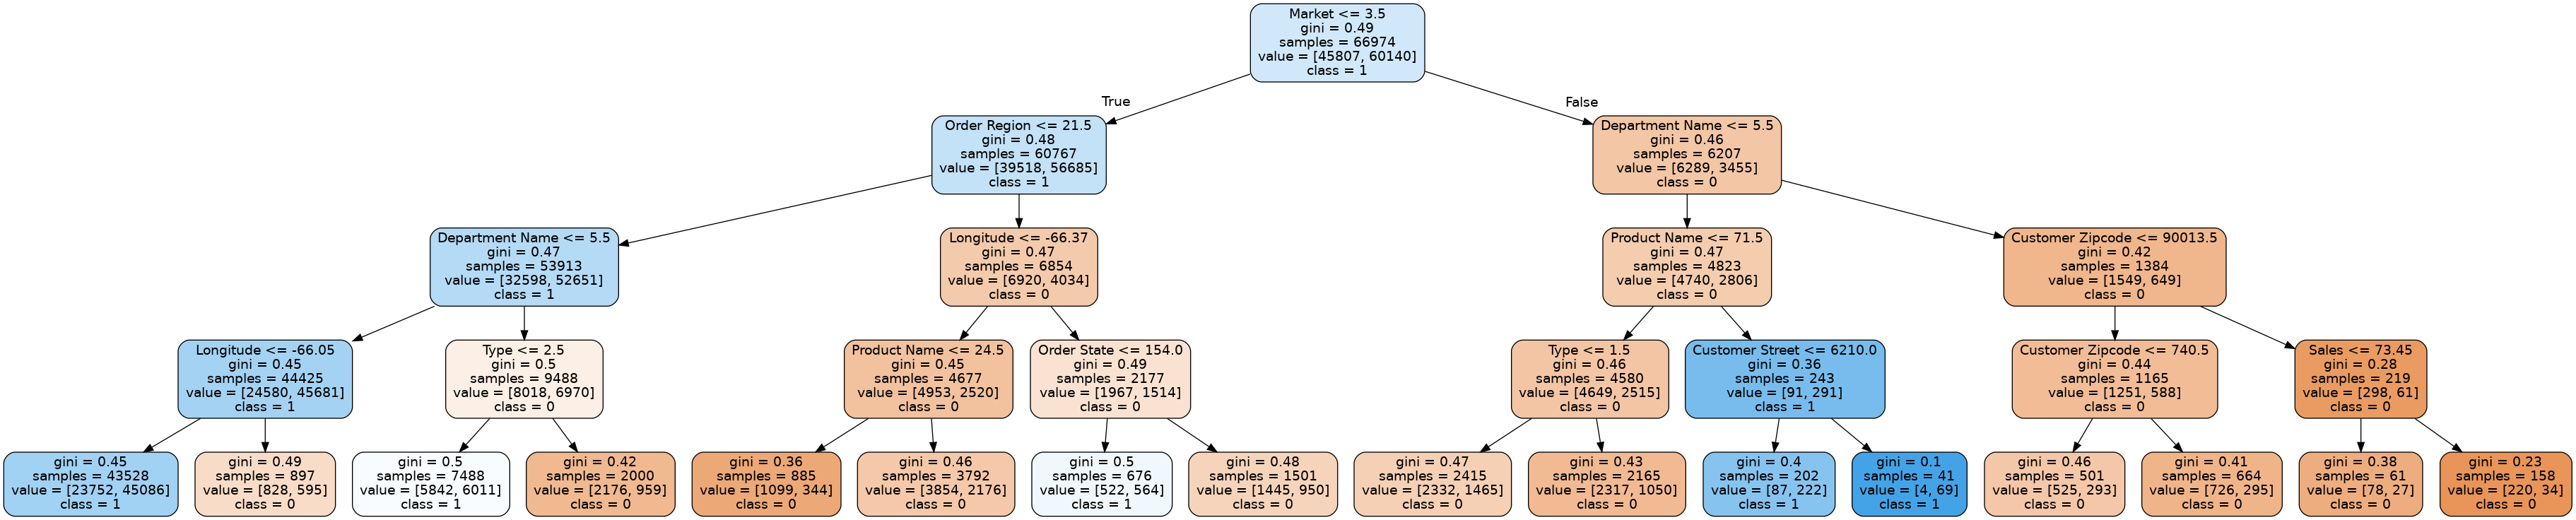

In [29]:
from IPython.display import Image
Image(filename='tree.png')

### Conclusion
My goal was to utilize supply chain data to predict if an order placed would end in a net loss.  I was able to successfully build a predictive model with a .88 accuracy score. Customer location seems to be a large determining factor within the model.  If this model were to be applied to the current dataset, a net profit of 1.2 million could be made.  One theoretical application for this model could be point of sale intervention to limit loss.  

If more resources were availible, I would have wanted to better analyize the results with a goal towards explaining why the model was working.  Furthermore, the model would need to be packaged in a way that a client could easily extract insights. This could be the form of a buisness analytics tool or easy to run script. 